<a href="https://colab.research.google.com/github/DavidePanza/ml-jaguar-identification/blob/main/notebooks/03_modeling/dino2_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import os
import sys
import random
from pathlib import Path
import torch
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/gdrive')

!pip install wandb
import wandb

!pip install fiftyone -q
import fiftyone as fo
from fiftyone import ViewField as FO

from google.colab import userdata
wandb_api_key = userdata.get('wanddb_api')
try:
    wandb.login(key=userdata.get('wanddb_api'))
except:
    print("Please add WANDB_API_KEY to Colab secrets")
    wandb.login()

# import from dino2_utils
notebook_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
src_path = os.path.join(notebook_dir, 'src')
sys.path.append(src_path)
from dino2_utils import DINOv2ArcFace, JaguarDataset, JaguarDatasetProcessor, FocalLoss, pad_to_square, setup_transform, get_embedding

# Overview
This script is designed to train and fine-tune a DINOv2-based model for jaguar classification. It loads and preprocesses the dataset, visualizes the label distribution, and prepares the DINOv2 model by loading pre-trained backbone weights. The model is then fine-tuned with a custom classifier head, utilizing Focal Loss for class imbalance. The training progress, including batch loss and accuracy, is logged through Weights and Biases. After training, the fine-tuned model is saved and evaluated on a test dataset to assess its classification performance. The process includes dataset handling, model training, logging, and model saving.

# Data Loading and Train/Test Split

In [ ]:
# Load the Dataset
image_dir = Path('path/to/your/images')
input_dir = Path('path/to/your/fo_dataset')
# Set path to unknown jaguars if additional unknown jaguars images are available. Otherwise skip this
unknown_jaguars_dir="/path/to/unknown/jaguars"

dataset = fo.Dataset.from_dir(
    dataset_dir=str(input_dir),
    dataset_type=fo.types.FiftyOneDataset,
    rel_dir=image_dir,
)

# Initialize the dataset processor
processor = JaguarDatasetProcessor(add_dataset_unknown_jaguars=True, add_unknown_jaguars=False, unknown_jaguars_dir=unknown_jaguars_dir)

# Process the dataset and display verification info
processor.process(dataset)

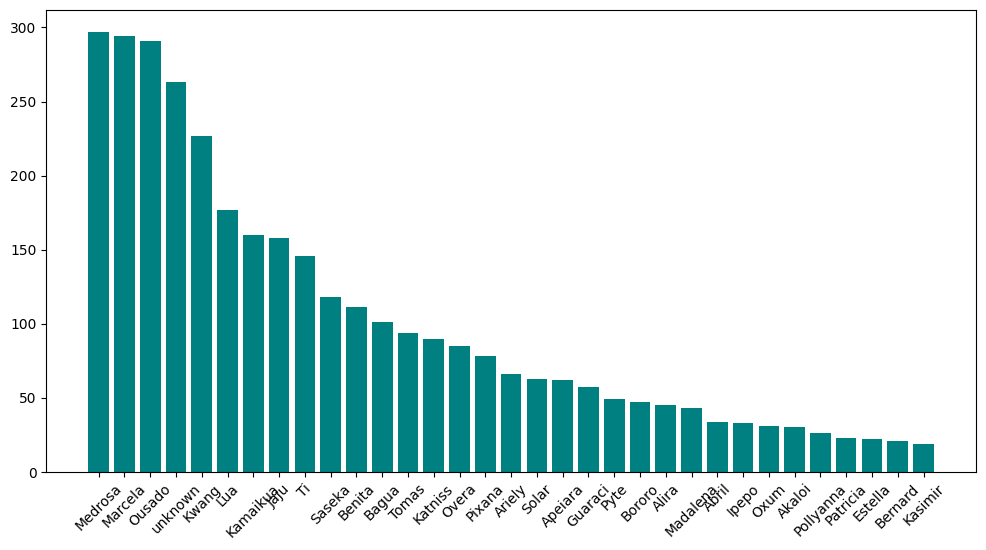

In [ ]:
# Visualise Number of Jaguars in the Train Split
label_counts = Counter(processor.train_labels_str)
labels, counts = zip(*sorted(label_counts.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='teal')
plt.xticks(rotation=45)
plt.show()

# Load the Finetuned Model
The code loads a pre-trained model's weights from a saved file and reconstructs the original model architecture. It then filters the weights to include only those corresponding to the model's backbone, and loads them into the model. Finally, it ensures the model is placed on the appropriate device (CPU or GPU).

In [ ]:
# Load the saved state_dict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/path/to/your/model.pth"
state_dict = torch.load(model_path, map_location="cpu")

# Reconstruct the original model
model = DINOv2ArcFace(usage="classifier", num_classes=processor.num_jaguars).to(device)

# Filter the state_dict to match the model's backbone weights (exclude non-relevant layers)
filtered_state_dict = {
    k: v for k, v in state_dict.items() if k.startswith("backbone")  # Adjust prefix as needed
}

# Load the filtered weights into the model
model.load_state_dict(filtered_state_dict, strict=False)

In [ ]:
# Hyperparameters
NUM_EPOCHS = 5
LR = 3e-4
BATCH_SIZE = 128

# Initialize Weights and Biases (wandb)
wandb.init(
    entity="jaguars",
    project="jaguars",
    config={
        "model": "finetuned dino2 classifier",
        "loss": "FocalLoss",
        "batch_size": BATCH_SIZE,
        "epochs": NUM_EPOCHS,
        "learning_rate": LR,
        "dataset": "segmented_body",
        "info": "...add info here..."
    }
)

# Initialize optimizer with a custom learning rate for the classifier
optimizer = torch.optim.Adam([
    {'params': model.classifier.parameters(), 'lr': LR}
])

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Weighted loss (Focal Loss with class weights)
class_counts = np.bincount(processor.train_labels)
class_weights = 1. / class_counts
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Instantiate FocalLoss with class weights
criterion = FocalLoss(weight=weights_tensor)

# Create DataLoader with image transformations
transform = setup_transform(use_padding=True, use_augmentation=True)  # Image transformation (e.g., padding)
dataset = JaguarDataset(image_paths=processor.train_image_paths, labels=processor.train_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

# Fine-tune the Classifier
This code trains the model for a set number of epochs, calculating the loss and accuracy for each batch. It logs both batch-level and epoch-level statistics, including loss and accuracy, to WandB. It also provides optional detailed debug information, like gradient flow and prediction confidence, when verbose is set to True.

In [ ]:
verbose = True

# Training Loop
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    correct_preds = 0  # Counter for correct predictions
    total_preds = 0    # Counter for total predictions

    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Get index of the max log-probability
        _, preds = torch.max(outputs, 1)

        # Calculate batch accuracy
        correct_preds = torch.sum(preds == labels).item()
        batch_accuracy = 100 * correct_preds / labels.size(0)
        epoch_loss += loss.item()

        # Print batch statistics
        print(f"Batch {batch_idx}:")
        if verbose:
            print("Predicted:", preds.tolist())
            print("Actual:   ", labels.tolist())
        print(f"Batch Accuracy: {batch_accuracy:.2f}%")
        print(f"Epoch Loss: {loss.item()}")

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Apply gradient clipping to avoid gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Step the optimizer
        optimizer.step()

        # Log batch loss
        wandb.log({
            "train/batch_loss": loss.item(),
            "train/batch_accuracy": batch_accuracy,
            "epoch": epoch,
            "batch": batch_idx,
        })

        if verbose:
            # Check gradient flow
            grad_norms = [p.grad.norm().item() for p in model.parameters() if p.grad is not None]
            print(f"Grad norms: {np.mean(grad_norms):.3e} ± {np.std(grad_norms):.3e}")

            # Check prediction distribution
            with torch.no_grad():
                probs = torch.softmax(outputs, dim=1)
                print(f"Pred distribution: min={probs.min():.3f} max={probs.max():.3f}")

            preds = outputs.argmax(dim=1)
            probs = torch.softmax(outputs, dim=1)
            confidences = probs[torch.arange(len(preds)), preds]

            correct_mask = preds == labels
            wrong_mask = ~correct_mask

            print(f"Correct pred mean confidence: {confidences[correct_mask].mean():.4f}")
            print(f"Wrong pred mean confidence:   {confidences[wrong_mask].mean():.4f}")

    # Calculate accuracy for this epoch
    if total_preds > 0:
        epoch_accuracy = 100 * correct_preds / total_preds
    else:
        epoch_accuracy = 0.0
    avg_epoch_loss = epoch_loss / len(dataloader)

    # Log epoch-level metrics (including accuracy)
    wandb.log({
        "train/epoch_loss": avg_epoch_loss,
        "epoch": epoch,
        "hyperparams/learning_rate": optimizer.param_groups[0]["lr"],
    })

    print(f"Epoch {epoch}, Loss: {avg_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Store the Finetuned Model

In [ ]:
# Save trained model
model_artifact = wandb.Artifact(
    name="Finetuned_classifier",
    type="model",
    description="...add your model description...",
)

# Save the model locally and add to artifact
model_path = "/path/to/store/your/model.pth"
torch.save(model.state_dict(), model_path)
model_artifact.add_file(model_path)

# Log the artifact to wandb
wandb.log_artifact(model_artifact)

# Finish WandB run
wandb.finish()

# Test the Model
Test the model accuracy using the test split

In [ ]:
# Load the model (if needed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/path/to/load/your/model.pth"
state_dict = torch.load(model_path, map_location="cpu")

# Reconstruct the original model
model = DINOv2ArcFace(usage="classifier", num_classes=processor.num_jaguars).to(device)

# Load the filtered weights into the model
model.load_state_dict(state_dict)

24
Batch Accuracy: 75.00%
49
Batch Accuracy: 76.56%
67
Batch Accuracy: 69.79%
89
Batch Accuracy: 69.53%
99
Batch Accuracy: 69.23%
Test Accuracy: 0.6923


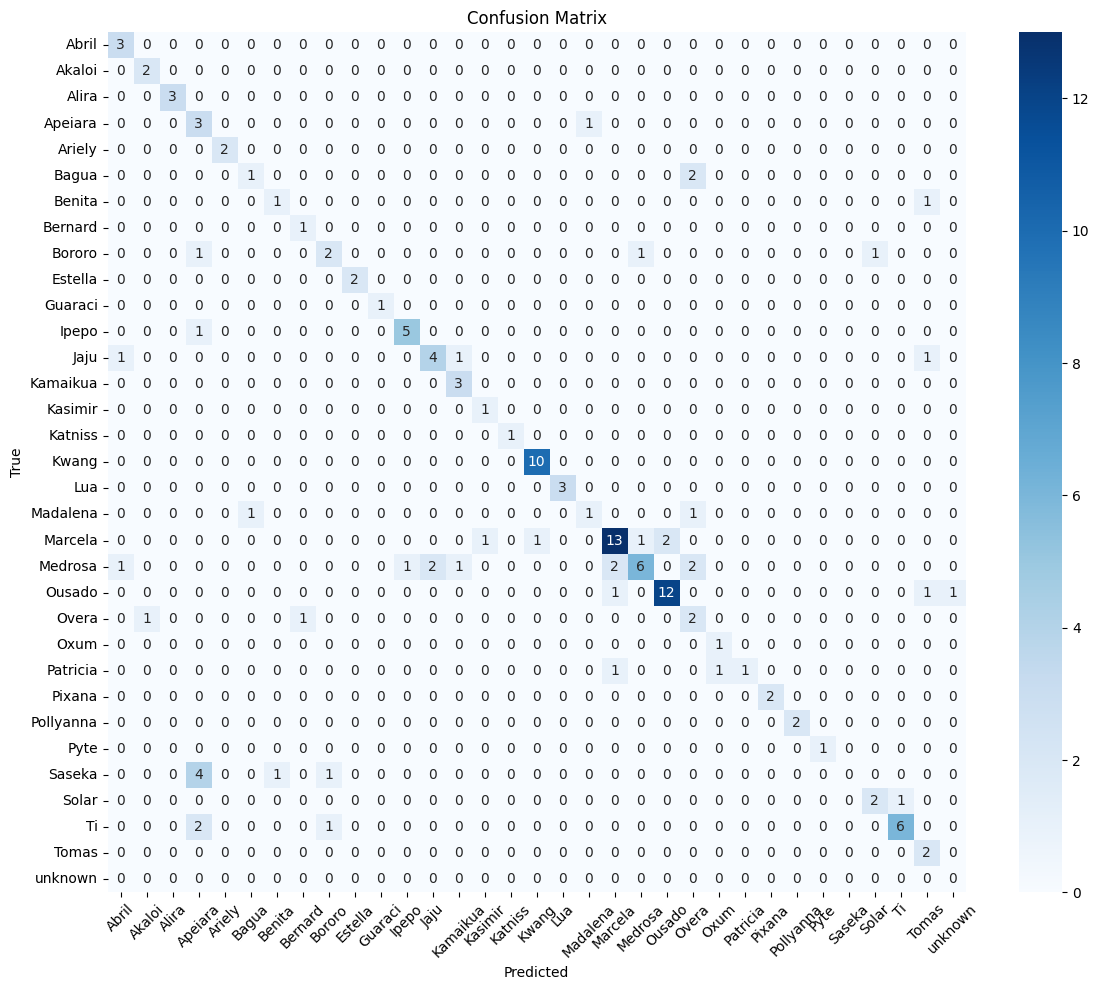

In [5]:
# Select test split (run inference on test images in batch)
BATCH_SIZE = 32
test_transform = setup_transform(use_padding=True, use_augmentation=False)
test_dataset = JaguarDataset(image_paths=processor.test_image_paths, labels=processor.test_labels, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialise
model.eval()
total_correct = 0
total_samples = 0

# Initialize lists to store all predictions and true labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predictions
        _, predictions = torch.max(outputs, 1)

        # Update counts
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        print(total_correct)
        print(f"Batch Accuracy: {100 * total_correct / total_samples:.2f}%")

# Calculate accuracy
test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Get class names from processor's name_to_int mapping
class_names = list(processor.name_to_int.keys())

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()